## 1. Introduction

* We aim to predict the likelihood of whether a person will default based information such as loan amount, annual income, and FICO score
* The dataset has 74 variables and 887,379 rows
* The response variable is **loan_status** which has 10 unique categories in the raw dataset
* We will perform some exploratory data analysis here

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams["figure.figsize"] = fig_size

## 2. EDA on Response Variable

In [3]:
# first get the dimension of the dataset
loan = pd.read_csv("loan.csv")
loan.shape

/Users/Mengxin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(887379, 74)

### 2.1 Count by loan status type (raw dataset)

In [4]:
# loan_status is the response variable
statusByType = loan.groupby('loan_status').size()
statusByType

loan_status
Charged Off                                             45248
Current                                                601779
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Does not meet the credit policy. Status:Fully Paid       1988
Fully Paid                                             207723
In Grace Period                                          6253
Issued                                                   8460
Late (16-30 days)                                        2357
Late (31-120 days)                                      11591
dtype: int64

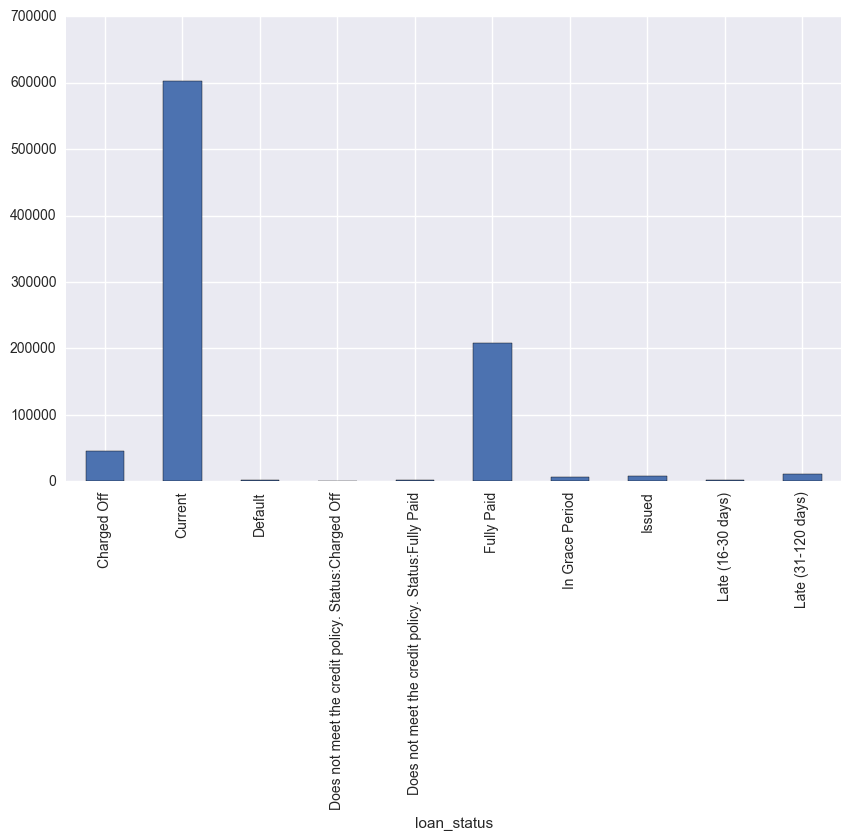

In [5]:
fig_size=[]
fig_size.append(10)
fig_size.append(6)
plt.rcParams["figure.figsize"] = fig_size
statusByType.plot(kind='bar')

### Summary: 

As the problem at hand is to predict whether a person will default, loans whose status is "current", "issued", or "late" are not closed yet. Therefore, we should drop observations assosiated with these categories.

### 2.2 Recreate response variable

In [6]:
## First drop categories that don't indicate whether a loan is defaulted
mask = loan['loan_status'].isin(['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off',
                                'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid'])
loan_new = loan[mask]
loan_new.groupby('loan_status').size()

loan_status
Charged Off                                             45248
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Does not meet the credit policy. Status:Fully Paid       1988
Fully Paid                                             207723
dtype: int64

In [7]:
## Next, regroup response variable
loan_new['status'] = np.where(loan_new['loan_status'].
                              isin(['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']),
                              'unpaid', 'paid')
loan_new.groupby('status').size()       

/Users/Mengxin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


status
paid      209711
unpaid     47228
dtype: int64

#### NOTE: By doing this filtering, we artifiially inflate the proportion of loans that default or are charged off. That's because defaulted and charged off loans reach theie termination (end status) faster than full paid loans in most cases.

In [8]:
fig_size=[]
fig_size.append(10)
fig_size.append(6)
plt.rcParams["figure.figsize"] = fig_size
statusByType_train.plot(kind='bar', width=0.3)

NameError: name 'statusByType_train' is not defined

### 2.3 Column Removal

* There are several columns that have the majority of values being NA's, therefore we drop the columsn with more than 100,000 NA's
* First let's count the # of NA's in each column

In [9]:
loan_new.isnull().sum()[1:35]

member_id                      0
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
term                           0
int_rate                       0
installment                    0
grade                          0
sub_grade                      0
emp_title                  14165
emp_length                     0
home_ownership                 0
annual_inc                     4
verification_status            0
issue_d                        0
loan_status                    0
pymnt_plan                     0
url                            0
desc                      166070
purpose                        0
title                         14
zip_code                       0
addr_state                     0
dti                            0
delinq_2yrs                   29
earliest_cr_line              29
inq_last_6mths                29
mths_since_last_delinq    142645
mths_since_last_record    224265
open_acc                      29
pub_rec   

In [10]:
loan_new.isnull().sum()[35:]

initial_list_status                 0
out_prncp                           0
out_prncp_inv                       0
total_pymnt                         0
total_pymnt_inv                     0
total_rec_prncp                     0
total_rec_int                       0
total_rec_late_fee                  0
recoveries                          0
collection_recovery_fee             0
last_pymnt_d                      548
last_pymnt_amnt                     0
next_pymnt_d                   252971
last_credit_pull_d                 23
collections_12_mths_ex_med        145
mths_since_last_major_derog    209063
policy_code                         0
application_type                    0
annual_inc_joint               256938
dti_joint                      256938
verification_status_joint      256938
acc_now_delinq                     29
tot_coll_amt                    66475
tot_cur_bal                     66475
open_acc_6m                    256795
open_il_6m                     256795
open_il_12m 

* Next let's drop columns with more than 100,000 NA's

In [11]:
def drop_sparse_columns(df):
    temp = df
    drop_col = []
    column_names = temp.columns.values
    for name in column_names:
        try:
            if temp[name].isnull().sum() > 100000: # drop columns with more than 80% NA's
                drop_col.append(name)
                temp.drop(labels=name, axis=1, inplace=True)
        except ValueError:
            pass
    return temp, drop_col

In [174]:
loan_new, drop_name = drop_sparse_columns(loan_new)
loan_new.shape

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(256939, 53)

In [175]:
drop_name

['desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [176]:
# further drop other columns
loan_new.drop(labels=['collection_recovery_fee',
                    'last_pymnt_amnt',
                    'last_pymnt_d',
                    'out_prncp',
                    'out_prncp_inv',
                    'pymnt_plan',
                    'recoveries',
                    'term',
                    'title',
                    'total_pymnt',
                    'total_pymnt_inv',
                    'total_rec_int',
                    'total_rec_late_fee',
                    'total_rec_prncp',
                    'url'], axis=1, inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [177]:
loan_new.shape

(256939, 38)

In [181]:
loan_new.iloc[:, 0:12].describe(include='all')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership
count,2.569390e+05,2.569390e+05,256939.000000,256939.000000,256939.000000,256939.000000,256939.000000,256939,256939,242774,256939,256939
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,35,134759,12,6
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B3,Manager,10+ years,MORTGAGE
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76617,18179,1959,77726,126598
mean,1.221284e+07,1.352047e+07,13522.115950,13479.995641,13360.648099,13.780014,416.923016,NaN,NaN,NaN,NaN,NaN
std,1.476914e+07,1.573908e+07,8128.811481,8106.456843,8141.904114,4.389704,244.878760,NaN,NaN,NaN,NaN,NaN
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,NaN,NaN,NaN,NaN,NaN
25%,1.438591e+06,1.683110e+06,7200.000000,7200.000000,7100.000000,10.740000,238.130000,NaN,NaN,NaN,NaN,NaN
50%,6.245475e+06,7.451894e+06,12000.000000,12000.000000,11950.000000,13.550000,364.290000,NaN,NaN,NaN,NaN,NaN
75%,1.643198e+07,1.847432e+07,18200.000000,18000.000000,18000.000000,16.550000,546.430000,NaN,NaN,NaN,NaN,NaN


In [182]:
loan_new.iloc[:, 12:26].describe(include='all')

,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal
count,2.569350e+05,256939,256939,256939,256939,256939,256939,256939.000000,256910.000000,256910,256910.000000,256910.000000,256910.000000,2.569390e+05
unique,NaN,3,103,5,14,889,51,NaN,NaN,646,NaN,NaN,NaN,NaN
top,NaN,Verified,Oct-2014,Fully Paid,debt_consolidation,945xx,CA,NaN,NaN,Oct-2000,NaN,NaN,NaN,NaN
freq,NaN,94002,8808,207723,150253,3316,43645,NaN,NaN,2143,NaN,NaN,NaN,NaN
mean,7.249885e+04,NaN,NaN,NaN,NaN,NaN,NaN,16.534986,0.250411,NaN,0.887821,10.935016,0.143354,1.530120e+04
std,5.890043e+04,NaN,NaN,NaN,NaN,NaN,NaN,7.793541,0.742431,NaN,1.158745,4.902947,0.436027,1.970880e+04
min,1.896000e+03,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000e+00
25%,4.500000e+04,NaN,NaN,NaN,NaN,NaN,NaN,10.740000,0.000000,NaN,0.000000,7.000000,0.000000,5.833000e+03
50%,6.200000e+04,NaN,NaN,NaN,NaN,NaN,NaN,16.200000,0.000000,NaN,1.000000,10.000000,0.000000,1.091800e+04
75%,8.700000e+04,NaN,NaN,NaN,NaN,NaN,NaN,21.990000,0.000000,NaN,1.000000,14.000000,0.000000,1.908350e+04


In [183]:
loan_new.iloc[:, 26:].describe(include='all')

,revol_util,total_acc,initial_list_status,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,status
count,256699.000000,256910.000000,256939,256916,256794.000000,256939.0,256939,256910.000000,1.904640e+05,1.904640e+05,1.904640e+05,256939
unique,NaN,NaN,2,103,NaN,NaN,2,NaN,NaN,NaN,NaN,2
top,NaN,NaN,f,Jan-2016,NaN,NaN,INDIVIDUAL,NaN,NaN,NaN,NaN,paid
freq,NaN,NaN,185496,103973,NaN,NaN,256938,NaN,NaN,NaN,NaN,209711
mean,54.315684,25.011732,NaN,NaN,0.006702,1.0,NaN,0.003106,2.033825e+02,1.381605e+05,2.969485e+04,NaN
std,24.827559,11.779200,NaN,NaN,0.088812,0.0,NaN,0.060409,2.103550e+04,1.523284e+05,2.949980e+04,NaN
min,0.000000,1.000000,NaN,NaN,0.000000,1.0,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,36.200000,16.000000,NaN,NaN,0.000000,1.0,NaN,0.000000,0.000000e+00,2.835575e+04,1.330000e+04,NaN
50%,55.800000,23.000000,NaN,NaN,0.000000,1.0,NaN,0.000000,0.000000e+00,8.076050e+04,2.230000e+04,NaN
75%,73.900000,32.000000,NaN,NaN,0.000000,1.0,NaN,0.000000,0.000000e+00,2.079905e+05,3.680000e+04,NaN


In [184]:
loan_new.shape

(256939, 38)

So we have removed columns with more than 100,000 missing values. We have also removed columns for extraneous reasons. Now of the columns left some comments:

- Employee title has 242,744 values of which 134,759 are Manager
- revol_util has only 256,699 values
- last_credit_pull_d has only 256,916 values
- collections_12_mths_ex_med might only have values equal to 6, but we will check

Here we see the number of unique employee titles:

In [185]:
len(list(loan_new['emp_title'].unique()))

134760

To make any use of this we would have to map these to fewer catgories. Maybe a count by category will help.

In [186]:
loan_new.groupby('emp_title').size()

emp_title
       NSA Industries llc                   1
   Bus Operator and Instructor              1
   Long Ilsand College Hospital             1
  BUS OPERATER                              1
  Golf Sevice Manager/ Caddie Master        1
  old palm inc                              1
 (RED),  a division of The ONE Campaign     1
 A Bell Pest Services                       1
 A Red Thread Adoption Services, Inc.       1
 ABC Supply Company                         1
 ADM                                        1
 ADVANTAGE SEPTIC SERVICE                   1
 AFJROTC Teacher                            1
 Airway Transportation System Specialist    1
 Andover Sub-Acute &Rehab Center            1
 Area Sales Manager                         1
 Behavior Specialist                        1
 Best Buy                                   1
 Bice president fixed income sales          1
 Box Cleaning                               1
 Brocade Communications                     1
 BusAttendantdept.oftran

Nah, this is a task too large for the project.

Now let's take a look at 'collections_12_mths_ex_med'

In [187]:
loan_new.groupby('collections_12_mths_ex_med').size()

collections_12_mths_ex_med
0.0    255201
1.0      1484
2.0        97
3.0         8
4.0         2
5.0         1
6.0         1
dtype: int64

In [188]:
loan_new.groupby('purpose').size()

purpose
car                     3720
credit_card            50649
debt_consolidation    150253
educational              422
home_improvement       15190
house                   1703
major_purchase          6402
medical                 2927
moving                  2085
other                  14766
renewable_energy         270
small_business          4926
vacation                1615
wedding                 2011
dtype: int64

## Feature Engineering

First, which features are left?

In [189]:
loan_new.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'status'], dtype=object)

In [192]:
# Let's add loan to income ratio
loan_new['loan_income_ratio'] = loan_new['loan_amnt'] / loan_new['annual_inc']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [193]:
# Now add installment to monthly payment ratio
loan_new['loan_income_ratio_month'] = loan_new['installment'] / (loan_new['annual_inc'] / 12)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## 4 Create training set and test set

### 4.1 Split Data

In [194]:
response = loan_new['status']
data = loan_new.drop(['status','loan_status'], axis=1)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(data, response, test_size=0.2, random_state=0)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [196]:
loan_new.groupby('collections_12_mths_ex_med').mean()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,revol_bal,revol_util,total_acc,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_income_ratio,loan_income_ratio_month
collections_12_mths_ex_med,,,,,,,,,,,,,,,,,,,,,
0.0,12149083,13452089,13527.566702,13485.327742,13367.779659,13.770927,417.052085,72481.415444,16.536236,0.247664,...,15322.742419,54.367644,24.997915,1.0,0.003002,194.643884,138160.306045,29726.817722,0.208772,0.078019
1.0,23253755,25407085,13371.276954,13371.276954,13365.397574,15.520640,418.177116,75018.495249,16.961489,0.657682,...,11987.352426,47.407345,27.603100,1.0,0.017520,1218.547170,136823.461590,25330.550539,0.199165,0.075343
2.0,27281592,29627403,13012.628866,13012.628866,13009.536082,15.137835,406.310103,79253.300206,17.748454,0.979381,...,11415.701031,37.386598,30.412371,1.0,0.041237,1529.567010,155542.659794,32595.783505,0.185528,0.069663
3.0,26221576,28711251,8512.500000,8512.500000,8493.750000,12.592500,269.581250,52200.000000,14.640000,1.125000,...,10379.875000,42.562500,27.375000,1.0,0.000000,1207.250000,166917.250000,22796.875000,0.164286,0.062963
4.0,33441592,36089893,13275.000000,13275.000000,13275.000000,16.690000,397.185000,68794.500000,19.165000,2.000000,...,14280.000000,46.500000,28.500000,1.0,0.000000,408.500000,33306.500000,44400.000000,0.241091,0.082969
5.0,16281089,18383643,20000.000000,20000.000000,20000.000000,10.150000,646.760000,205000.000000,13.260000,2.000000,...,181363.000000,39.300000,30.000000,1.0,0.000000,574.000000,541960.000000,208200.000000,0.097561,0.037859
6.0,33551290,36194558,20000.000000,20000.000000,19975.000000,14.310000,686.570000,54000.000000,35.440000,0.000000,...,14151.000000,41.000000,18.000000,1.0,0.000000,6726.000000,40609.000000,34500.000000,0.370370,0.152571


In [197]:
# loan_status is the response variable
statusByType_train = train['status'].value_counts()
statusByType_train

paid      167863
unpaid     37688
Name: status, dtype: int64

### 4.2 Impute Missing Values

### 4.3 Write to Files

In [216]:
train.to_csv('loan_train.csv')
test.to_csv('loan_test.csv')